<a href="https://colab.research.google.com/github/KubaSiwiec/hsi_spatial_spectral/blob/collab/hsi_learn_lbp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
'''
feature extraction functions
'''

import scipy.io
from skimage.util import view_as_windows
from skimage.util import pad
import numpy as np
from skimage.feature import local_binary_pattern, hog


def get_data(file_name):
    return scipy.io.loadmat(file_name)

def get_patches(image, size = 3, use_padding = 'SAME'):

    # add padding for image to make it able to extract the number of patches equal to number of pixels
    # the pad width should eqal (patch size - 1) / 2,  - center pixel will always lay in original image
    nb_padding_pixels = int(size/2 - 0.5)
    # choose symmetric mode
    image_padded = pad(image, nb_padding_pixels, 'symmetric')

    patch_size = (size, size, image.shape[2])
    patches = view_as_windows(image_padded, patch_size)[:, :, 0]
    return patches

def hsi_to_lbp(image, radius, n_points):

    image_shape = image.shape
    image_depth = image_shape[2]


    lbp_map = np.zeros(image.shape)
    
    for k in range(image_depth):
        # compare each pixel greyscale value with the central pixel
        lbp_map[:, :, k] = local_binary_pattern(image[:, :, k], n_points, radius)

    return lbp_map


def getCLBPlayer(image, radius):
    '''
    == Input ==
    gray_image  : color image of shape (height, width)
    
    == Output ==  
    imgLBP : LBP converted image of the same shape as 
    '''
    

    imgCLBP = np.zeros(image.shape)
    radius = 3 
    for ih in range(0,image.shape[0] - radius):
        for iw in range(0,image.shape[1] - radius):
            ### Step 1: 3 by 3 pixel
            img = image[ih:ih+radius,iw:iw+radius]
            img_mean = np.mean(img)
            img01 = (img >= img_mean)*1.0
            img01_vector = img01.T.flatten()
            # it is ok to order counterclock manner
            # img01_vector = img01.flatten()
            ### Step 2: **Binary operation**:
            img01_vector = np.delete(img01_vector,4)
            ### Step 3: Decimal: Convert the binary operated values to a digit.
            where_img01_vector = np.where(img01_vector)[0]
            if len(where_img01_vector) >= 1:
                num = np.sum(2**where_img01_vector)
            else:
                num = 0
            imgCLBP[ih+1,iw+1] = num
    return(imgCLBP)

def hsi_to_clbp(image, radius):

    image_shape = image.shape
    image_depth = image_shape[2]


    clbp_map = np.zeros(image.shape)
    
    for k in range(image_depth):
        # compare each pixel greyscale value with the central pixel
        clbp_map[:, :, k] = getCLBPlayer(image[:, :, k], radius)

    return clbp_map


def hsi_to_hog(image, radius):

    image_shape = image.shape
    image_depth = image_shape[2]

    hog_lst = []
    
    for k in range(image_depth):
        # compare each pixel greyscale value with the central pixel
        hog_lst.append(hog(image[:, :, k]))

    hog_arr = np.asarray(hog_lst)

    return hog_arr


def hsi_to_wtf(image):

    image_shape = image.shape
    image_width = image_shape[0]
    image_height = image_shape[1]
    image_depth = image_shape[2]

    # print("Shape: {}, Width: {}, Height: {}, Depth: {}".format(image_shape, image_width, image_height, image_depth))

    #get the image shape
    central_pixel = image[int((image_width - 1) / 2), int((image_height - 1) / 2), :]

    # print("Central pixel: {}".format(central_pixel))

    lbp_map = np.zeros(image.shape)
    # dimensions of the image: (image_width,image_height,image_depth)
    # for each of k channels
    for k in range(image_depth):
        # compare each pixel greyscale value with the central pixel
        for i in range(image_width):
            for j in range(image_height):
                if image[i,j,k] >= central_pixel[k]:
                    lbp_map[i,j,k] = True
                elif image[i,j,k] < central_pixel[k]:
                    lbp_map[i,j,k] = False
                # setting the central pixel to 0.5 removes the noisy pixel from the middle of a image
                #but LBP map stops to be binary
                #when using it, remove the eqaul sign from the first conditional equation
                # else:
                #     lbp_map[i,j,k] = 0.5

    print('lbp map: {}'.format(lbp_map))

    return lbp_map


def hsi_to_mwtf(image):
    #here, the treshold will be set as mean of the image, not as value of specific central pixel

    image_shape = image.shape
    image_width = image_shape[0]
    image_height = image_shape[1]
    image_depth = image_shape[2]

    # print("Shape: {}, Width: {}, Height: {}, Depth: {}".format(image_shape, image_width, image_height, image_depth))

    #get the image shape
    central_pixel = image[int((image_width - 1) / 2), int((image_height - 1) / 2), :]

    # print("Central pixel: {}".format(central_pixel))

    clbp_map = np.zeros(image.shape)
    # dimensions of the image: (image_width,image_height,image_depth)
    # for each of k channels
    for k in range(image_depth):
        # compare each pixel greyscale value with the mean of the image

        #get mean of a layer
        channel_mean = np.mean(image[:, :, k])
        for i in range(image_width):
            for j in range(image_height):
                if image[i,j,k] >= channel_mean:
                    clbp_map[i,j,k] = 1
                elif image[i,j,k] < channel_mean:
                    clbp_map[i,j,k] = 0

    return clbp_map





def hs_to_grey(image):
    return np.mean(image, axis = 2)

def arr2D_to_list(arr: np.array):
    dims = len(arr.shape)
    lst = []
    if dims == 2:
        print('Gt width: {}, length: {}'.format(arr.shape[0], arr.shape[1]))
        for i in range(arr.shape[0]):
            for j in range(arr.shape[1]):
                lst.append(arr[i, j])

        return lst
    else:
        raise Exception('Array should be two dimentional')

def arr5D_to_list_of_3D_arr(arr: np.array):
    dims = len(arr.shape)
    lst = []
    if dims == 5:
        for i in range(arr.shape[0]):
            for j in range(arr.shape[1]):
                    lst.append(arr[i, j])
        return lst
    else:
        raise Exception('Array should be two dimentional')





In [3]:
'''
create CNN model function
'''
from tensorflow import keras

# model definition function
def create_model_CNN(l2_loss_lambda = None):
    keras.backend.clear_session()

    target_size = (32, 32)
    l2 = None if l2_loss_lambda is None else keras.regularizers.l2(l2_loss_lambda)
    if l2 is not None:
        print('Using L2 regularization - l2_loss_lambda = %.4f' % l2_loss_lambda)

    model = keras.Sequential(
        [
            keras.layers.Lambda(lambda image: tf.image.resize(image, target_size)),
            keras.layers.Conv2D(256, 3, activation=tf.nn.relu, input_shape=(32, 32, 103)),
            keras.layers.MaxPool2D(2),
            keras.layers.Conv2D(512, 3, activation=tf.nn.relu),
            keras.layers.MaxPool2D(2),
            keras.layers.Flatten(),
            keras.layers.Dense(512, activation=tf.nn.relu, kernel_regularizer=l2),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(10, activation=tf.nn.softmax),
        ]
    )

    # model compiling

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

    return model

In [4]:
'''
RNN LSTM
'''

from tensorflow import keras

# model definition function
def create_model_LSTM(l2_loss_lambda = None, input_shape = (3, 309)):
    keras.backend.clear_session()

    # target_size = (32, 32)
    l2 = None if l2_loss_lambda is None else keras.regularizers.l2(l2_loss_lambda)
    if l2 is not None:
        print('Using L2 regularization - l2_loss_lambda = %.4f' % l2_loss_lambda)

    model = keras.Sequential(
        [
            # keras.layers.Lambda(lambda image: tf.image.resize(image, target_size)),
            tf.compat.v1.keras.layers.CuDNNLSTM(1024, input_shape = input_shape, return_sequences = True),
            keras.layers.Dropout(0.2),
         
            tf.compat.v1.keras.layers.CuDNNLSTM(1024),
            keras.layers.Dropout(0.2),
         
            keras.layers.Dense(256, activation=tf.nn.relu, kernel_regularizer=l2),
            keras.layers.Dropout(0.2),
            
            keras.layers.Dense(10, activation=tf.nn.softmax),
        ]
    )

    # model compiling

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

    return model

In [5]:
import gc
class GarbageCollectorCallback(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs=None):
    gc.collect()


In [6]:
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import matplotlib.pyplot as plt

In [7]:
mat = get_data("/content/drive/My Drive/PaviaU.mat")
# print(mat)

mat_gt = get_data("/content/drive/My Drive/PaviaU_gt.mat")
# print(mat_gt

data = mat['paviaU']
ground_truth = mat_gt['paviaU_gt']

print("Shape of the cube: {}".format(data.shape))
print("Shape of the labels_arr: {}".format(ground_truth.shape))
print("Number of classes: {}".format(np.unique(ground_truth)))

print("Maximum value: {}".format(np.argmax(data)))

print("Index of maximum value: {}".format(np.unravel_index(np.argmax(data), data.shape)))












Shape of the cube: (610, 340, 103)
Shape of the labels_arr: (610, 340)
Number of classes: [0 1 2 3 4 5 6 7 8 9]
Maximum value: 396299
Index of maximum value: (11, 107, 58)


In [8]:
mat = get_data("/content/drive/My Drive/PaviaU.mat")

mat_gt = get_data("/content/drive/My Drive/PaviaU_gt.mat")

mat_training = get_data("/content/drive/My Drive/PaviaU_tr.mat")


data = mat['paviaU']
ground_t = mat_gt['paviaU_gt']
ground_truth = ground_t.flatten()
training_data_full = mat_training['PaviaUni_train'].flatten()

training_indeces = np.asarray(np.where(training_data_full > 0))
testing_indices = np.asarray(np.where(ground_truth > 0))

training_labels = np.take(training_data_full, training_indeces, axis = 0).flatten()
testing_labels = np.take(ground_truth, testing_indices, axis = 0).flatten()


print("Shape of the cube: {}".format(data.shape))
print("Shape of the labels_array: {}".format(ground_truth.shape))
print("Shape of training labels array: {}".format(training_data_full.shape))
print("Shape of training indeces array: {}".format(training_indeces.shape))
print("Training labels classes: {}".format(np.unique(training_labels)))
print("Number of classes: {}".format(np.unique(ground_truth)))
print("Shape of testing indices array: {}".format(testing_indices.shape))
print("Shape of testing labels array: {}".format(testing_labels.shape))





print("Maximum value: {}".format(np.argmax(data)))

print("Index of maximum value: {}".format(np.unravel_index(np.argmax(data), data.shape)))













Shape of the cube: (610, 340, 103)
Shape of the labels_array: (207400,)
Shape of training labels array: (207400,)
Shape of training indeces array: (1, 3921)
Training labels classes: [1 2 3 4 5 6 7 8 9]
Number of classes: [0 1 2 3 4 5 6 7 8 9]
Shape of testing indices array: (1, 42776)
Shape of testing labels array: (42776,)
Maximum value: 396299
Index of maximum value: (11, 107, 58)


In [9]:
# apply lbp and clbp on image
radius = 3
processed_image = hsi_to_lbp(data, radius, radius * 8)
print('LBP image shape: {}'.format(processed_image.shape))
print(np.int_(processed_image/10000))

processed_image = np.int_(processed_image/10000/1677*255)
print(np.max(processed_image))







LBP image shape: (610, 340, 103)
[[[1546 1546 1336 ...    0    0    0]
  [1612 1585  249 ...    0    0    0]
  [1425    3    9 ...    0    0    0]
  ...
  [ 418  179    1 ...    3    3    4]
  [ 101  104  209 ...   84   84   84]
  [  49   49   50 ...   52   52   52]]

 [[1284   26   26 ...    0    0    0]
  [   0   13  249 ...    0    0    0]
  [ 835 1582    9 ...    0    0    0]
  ...
  [   0  186  396 ...    0    0    0]
  [  13    0    0 ...   81   81   81]
  [   0    0   49 ...   52   52   52]]

 [[   0    0   26 ...    0    0    0]
  [1671 1297   13 ...   39   39   39]
  [   0  629 1622 ... 1671 1671 1671]
  ...
  [ 210  106  393 ...  209  209  209]
  [ 209  205   52 ...  101  101  101]
  [   3   49   51 ...   46   46   46]]

 ...

 [[1468 1468 1468 ...  838 1258 1258]
  [1468  838    0 ... 1258 1258 1468]
  [1468 1258    0 ... 1468 1468 1468]
  ...
  [   0    0    0 ...    0    0    1]
  [   6    6 1677 ...    0    0    0]
  [   0    0    0 ...    1    1    1]]

 [[ 838  838    0

In [10]:
#crop patches
patch_size = 9
data_patches = get_patches(processed_image, patch_size)
print('LBP patches shape: {}'.format(data_patches.shape))

LBP patches shape: (610, 340, 9, 9, 103)


In [11]:
pip install spectral

ImageView object:
  Display bands       :  [0, 51.5, 102]
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 8000.0]
    G: [0.0, 8000.0]
    B: [0.0, 8000.0]

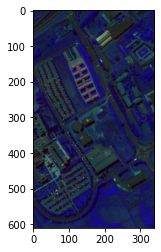

In [12]:
import spectral
spectral.imshow(data)

TypeError: ignored

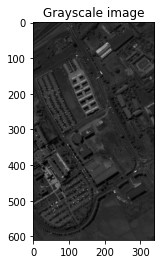

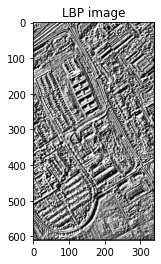

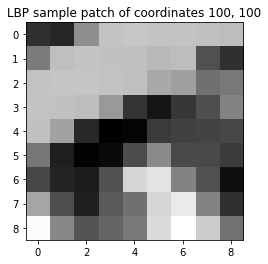

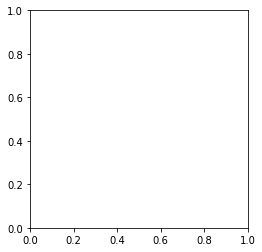

In [13]:
'''
Plotting images
'''

#compare greyscale image with lbp map
plt.figure(1)
plt.imshow(hs_to_grey(data), cmap='gray')
plt.title("Grayscale image")

plt.figure(2)
plt.imshow(hs_to_grey(processed_image), cmap='gray')
plt.title("LBP image")

# present some patches of lbp data
plt.figure(4)
co_x = 100
co_y = 100
plt.imshow(hs_to_grey(data_patches[co_x, co_y]), cmap='gray')
plt.title("LBP sample patch of coordinates {}, {}".format(co_x, co_y))

plt.figure(6)
plt.imshow(ground_truth)
plt.title('Classes')

plt.show()

#free memory
data = None
processed_image = None

In [ ]:
spectral.imshow(data_patches[co_x, co_y])
co_x = None
co_y = None
gc.collect()

In [ ]:
'''
Save patches and ground truth into arrays
'''

# patches
# patch_arr = np.asarray(arr5D_to_list_of_3D_arr(data_patches), dtype=np.uint8)
training_patch_arr = np.resize(np.take(np.asarray(arr5D_to_list_of_3D_arr(data_patches), dtype=np.uint8), training_indeces, axis = 0), (training_labels.shape[0], patch_size, patch_size, 103))
testing_patch_arr = np.resize(np.take(np.asarray(arr5D_to_list_of_3D_arr(data_patches), dtype=np.uint8), testing_indices, axis = 0), (testing_labels.shape[0], patch_size, patch_size, 103))

print(testing_patch_arr.shape)
print('patch_lbp_list len: {}'.format(training_patch_arr.shape))
data_patches = None
gc.collect()

# ground truth
labels_gt = ground_truth.flatten()
print("Labels len: {}".format(len(labels_gt)))
print(np.unique(labels_gt))
ground_truth = None


In [ ]:
'''
split data to training and validation datasets
'''
gc.collect()

val_split = 0.12
X_train, X_val, y_train, y_val = train_test_split(training_patch_arr, training_labels, test_size=val_split, stratify=training_labels)

#free memory
# patches_sequence = None
label_gt = None

In [ ]:
'''
Create and fit model, get loss, accuracy and f1-score metrics
'''
model = create_model_CNN(None)

gc.collect()
history = model.fit(X_train, y_train, batch_size = 32, epochs=200, validation_data=(X_val, y_val))
print(model.summary())

In [ ]:
'''
Plot accuracy
'''

plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train accuracy', 'val accuracy'])
plt.title("LBP, CNN, {}x{} patch".format(patch_size, patch_size))
plt.show()

In [ ]:
'''
get predictions and predicted labels
'''

predictions = model.predict(X_val)
gt_predicted = [np.argmax(prediction) for prediction in predictions]


In [ ]:
'''
Calculate kappa coefictient
'''

from sklearn.metrics import cohen_kappa_score, f1_score

kappa = cohen_kappa_score(y_val, np.array(gt_predicted))
f1 = f1_score(y_val, np.array(gt_predicted), average = 'weighted')
print("Kappa: {}, F1: {}".format(kappa, f1))

In [ ]:
predictions_test = model.predict(testing_patch_arr)
gt_predicted_test = [np.argmax(prediction) for prediction in predictions_test]

In [ ]:
result = model.evaluate(testing_patch_arr, testing_labels)

kappa_test = cohen_kappa_score(testing_labels, np.array(gt_predicted_test))
f1_test = f1_score(testing_labels, np.array(gt_predicted_test), average = 'weighted')
print("Testing accuracy: {}\nKappa: {}\nF1: {}".format(result,kappa_test, f1_test))

In [ ]:
# import os, sys
# sys.path.append(os.path.join(os.getcwd(), "keras-deep-graph-learning")) # Adding the submodule to the module search path
# sys.path.append(os.path.join(os.getcwd(), "keras-deep-graph-learning/examples")) # Adding the submodule to the module search path
# import numpy as np
# from keras.layers import Dense, Activation, Dropout
# from keras.models import Model, Sequential
# from keras.regularizers import l2
# from keras.optimizers import Adam
# from keras_dgl.layers import GraphCNN
# import keras.backend as K
# from keras.utils import to_categorical

# print("Creating our simple sample data...")
# A = np.array([[0,1,5], [1,0,0], [5,0,0]])
# print(A)
# X = np.array([[1,2,10], [4,3,10], [0,2,11]]) # features, whatever we have there...

# # Notice, if we set A = identity matrix, then we'd effectively assume no edges and just do a basic
# # MLP on the features.

# # We could do the same by setting the graph_conv_filter below to Id.

# # We could also set X to Id, and thus effectively assume no features, and in this way
# # do an "edge" embedding, so effectively try to understand what's connected to what.

# # We could then use that as feature in any way we like...

# Y_o_dim = np.array([1,2,1])
# Y =  to_categorical(Y_o_dim) # labels, whatever we wanna classify things into... in categorical form.